In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

##################  Загрузка данных
Xtrain = pd.read_csv('D:\Coding\data\phone_user_review_file_60.csv', encoding= 'utf-8')
Xtest = pd.read_csv('D:\Coding\data\phone_user_review_file_40.csv', encoding= 'utf-8')

In [2]:
print("Xtrain.shape(): ", Xtrain.shape,
      "\nXtest.shape(): ", Xtest.shape)

Xtrain.shape():  (163837, 11) 
Xtest.shape():  (98284, 11)


In [3]:
print("Xtrain.head():\n", Xtrain[['lang', 'score', 'extract']].head())

Xtrain.head():
   lang  score                                            extract
0   en    8.0  I've had the phone for awhile and it's a prett...
1   en    6.0  to be clear it is not the sellers fault that t...
2   en    9.0  Well i love this phone. i have had ton of phon...
3   en    4.0  I have had my Instinct for several months now ...
4   en    6.0  i have had this instinct phone for about two m...


In [ ]:
##################  Препроцессинг

In [4]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    #words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [6]:
# Преобразуем время
# Разделение времени на год и месяц
Xtrain['date'] = Xtrain['date'].apply(pd.to_datetime)
Xtrain['year'] = Xtrain['date'].apply(lambda x: x.year)
Xtrain['month'] = Xtrain['date'].apply(lambda x: x.month)

In [7]:
#Валидация на 2016 годе
Xtr = Xtrain[(Xtrain['year']==2015) & (Xtrain.lang == 'en')].head(200)
Xval = Xtrain[(Xtrain['year']==2016) & (Xtrain.lang == 'en')].head(50)
#score - оценка телефона
ytr = Xtr['score']
yval = Xval['score']

In [8]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 13) 
Xval.shape():  (50, 13) 
ytr.mean():  7.925 
yval.mean():  8.22


In [9]:
data = pd.concat([Xtr,Xval],axis = 0,ignore_index = True)

#у нас есть nan, поэтому преобразуем их к строке
data['content_clear'] = data['extract'].apply(str)
data['content_clear'] = data['content_clear'].apply(review_to_wordlist)

In [12]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['price', 'expected', 'phone', 'beat', 'work']


############## Word2vec ##############

In [13]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Тренировка модели
# size - размер вектора
#min_count - игнорирует все слова с total frequency меньше заданного значения
#workers - количество ядер PC
#window - максимальная дистанция между текущем словом и прогнозируемом в предложении

#model_w2v = word2vec.Word2Vec(data['content_clear'], size=50, window=10, workers=cpu_count())


#Скачивание готовой натренированной модели
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [16]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [17]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(250, 300)

In [18]:
def split(train,y,ratio):
    idx = ratio
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]
y = data['score']
Xtr, Xval, ytr, yval = split(data_mean, y,200)

In [19]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 300) 
Xval.shape():  (50, 300) 
ytr.mean():  7.925 
yval.mean():  8.22


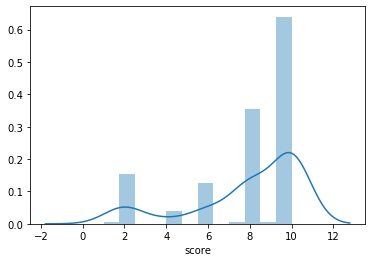

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############## Random Forest ##############

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Random Forest классификатор
clf_rf = RandomForestClassifier()

#n_estimators - количество деревьев
parameters = {'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7, 10]}

In [27]:
#классификатор GridSearchCV
grid_search_cv_clf_rf = GridSearchCV(clf_rf, parameters, cv=5)
grid_search_cv_clf_rf.fit(Xtr, ytr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [28]:
print(
    '\nРекомендуемые параметры: ',
    grid_search_cv_clf_rf.best_params_ #выбор параметров, для которых значение accuracy будет максимальным на кросс-валидационном множестве, а не просто на обучающей выборке
)


Рекомендуемые параметры:  {'max_depth': 2, 'n_estimators': 10}


In [29]:
best_clf = grid_search_cv_clf_rf.best_estimator_

In [30]:
feature_importances = best_clf.feature_importances_

#Набор фичей, который показывает по каким из них нужно было сделать сплиты,
# чтобы добиться максимольного снижения энтропии данных
#feature_importances_df = pd.DataFrame({'features':list(X_train),
#                                       'feature_importances':feature_importances})
print(feature_importances)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.061678   0.         0.         0.
 0.         0.         0.         0.02216748 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02239675 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.03945538 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.04400085 0.         0.         0.         0.
 0.03085035 0.         0.         0.         0.03591021 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.08915302 0.0264969  0.
 0.         0.         0.         0.         0.         

In [31]:
feature_importances_df = pd.DataFrame({'features':list(Xtr),
                                      'feature_importances':feature_importances})

ValueError: arrays must all be same length

In [32]:
feature_importances_df = pd.DataFrame(list(zip(Xtr, feature_importances)),
                                 columns = ['features', 'feature_importances'])

feature_importances_df = feature_importances_df.sort_values('feature_importances', ascending=False)

print('\nfeature_importances_df: \n', feature_importances_df)


feature_importances_df: 
                                               features  feature_importances
93   [0.00487264, -0.0030053456, -0.086901344, 0.08...             0.089153
8    [-0.016639123, -0.03158804, -0.009213961, 0.04...             0.061678
177  [0.04099528, -0.034505207, 0.080225624, -0.014...             0.058990
73   [-0.0124053955, -0.02281189, -0.0345459, 0.057...             0.044001
144  [0.017844705, 0.022091135, -0.045148063, 0.136...             0.040098
..                                                 ...                  ...
70   [-0.0038230203, 0.080028184, 0.03387451, 0.007...             0.000000
71   [0.04654948, 0.15174358, -0.10725912, 0.040242...             0.000000
72   [0.044270832, -0.03133138, 0.04663086, 0.15534...             0.000000
74   [0.010477702, -0.0689799, 0.032836914, 0.08172...             0.000000
199  [0.00030081611, 0.013383411, -0.07648286, 0.04...             0.000000

[200 rows x 2 columns]


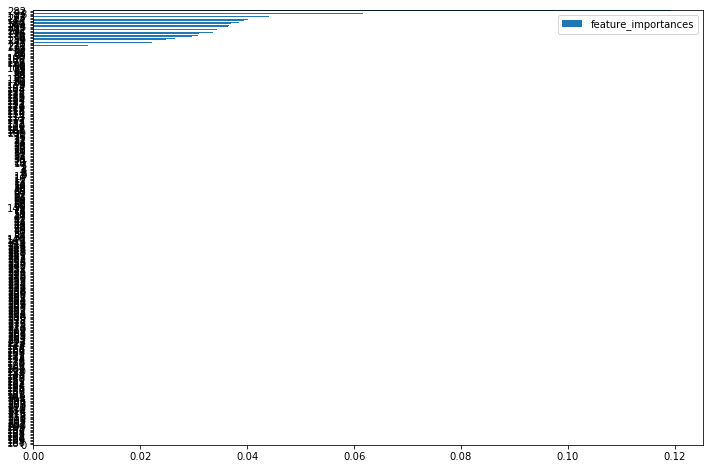

In [33]:
imp = pd.DataFrame(best_clf.feature_importances_, columns=['feature_importances'])
imp.sort_values('feature_importances').plot(kind='barh', figsize=(12, 8))
plt.show()